# A1. US Presidential Speeches 

In [40]:
# import needed libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import contractions
import string
import nltk
from nltk.corpus import inaugural
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Create corpus

In [18]:
df = pd.read_csv("presidents.csv", header=0)

In [3]:
# create an empty dictionary with information we need
corpus_dict = {
    "year":[],
    "president":[],
    # add party affiliation using preloaded dataframe
    "party":list(df.party),
    "n_vocab":[],
    "top5_vocabs":[],
    #"theme":[],
    "polarity":[]
    }

### Add year of speech and name of president

### Preprocessing steps

In [4]:
def preprocess(file_name):
    # load the speech and convert to lowercase
    speech = inaugural.raw(file_name).lower()

    # expand contractions
    expanded_words = [contractions.fix(word) for word in speech.split()]
    speech = ' '.join(expanded_words)

    # remove punctuations: using translate
    speech = speech.translate(str.maketrans('', '', string.punctuation))

    # tokenize
    tokens_raw = speech.split()

    # limit to tokens with more than 2 characters
    tokens_raw = [token for token in tokens_raw if len(token) > 2]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens_filtered = [token for token in tokens_raw if not token in stop_words]

    # add POS tags for ease in lemmatization
    tokens_tagged = pos_tag(tokens_filtered)

    # define a lemmatizing function that uses POS tags
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)


    # Lemmatize filtered_tokens using the defined function
    tokens_lemmatized = [WordNetLemmatizer().lemmatize(token, get_wordnet_pos(token)) for token in tokens_filtered]
    
    return tokens_raw, tokens_lemmatized

In [5]:

for fileid in inaugural.fileids():
    # matching pattern to extract name of presidents from fileids
    regex = "\\-(.*?)\\."

    # add year of speech and name of president to the dictionary
    match = re.findall(regex, fileid)[0] # pattern to extract name

    corpus_dict["year"].append(int(fileid[:4]))
    corpus_dict["president"].append(match)

    # preprocess the text using defined preprocess function
    tokens_uncleaned, tokens_cleaned = preprocess(fileid)

    # add size of vocabularies to the dictionary
    corpus_dict["n_vocab"].append(len(tokens_cleaned))

    # add top 5 most used vocabularies
    freq = nltk.FreqDist(tokens_cleaned).most_common(5)
    top5words = list(list(zip(*freq))[0])
    corpus_dict["top5_vocabs"].append(top5words)

    # calculating polarity
    negative_words = 0
    positive_words = 0
    pol_words = 0
    sum_pol = 0.0

    for w in tokens_uncleaned:
        pol = SentimentIntensityAnalyzer().polarity_scores(w)
        if pol["compound"] != 0:
            pol_words += 1
            sum_pol = sum_pol + pol["compound"]
        if pol["neg"] > 0:
            negative_words += 1 
        if pol["pos"] > 0:
            positive_words += 1

    polarity = sum_pol/pol_words
    corpus_dict["polarity"].append(round(polarity,2))

In [17]:
data = pd.DataFrame.from_dict(corpus_dict)
# data.to_csv("df_speeches.csv")

In [28]:
# load the updated dataframe
df_updated = pd.read_csv("df_speeches.csv")

### Add party affiliation (Democrat/Republican/Other)

##### Which presidents have the most vocabulary

In [ ]:
# president with most vocabularies
df_updated.sort_values(by=['n_vocab'], ascending=False)[['year','president', 'n_vocab']][:5]

##### Which president has the least vocabulary

In [ ]:
# presidents with least vocabularies
df_updated.sort_values(by=['n_vocab'], ascending=False)[['year','president', 'n_vocab']][-3:]

##### On average, do Democratic, Republican, or Other presidents have higher vocabulary?

In [35]:
df_updated[["party", "n_vocab"]].groupby(["party"]).mean()

,n_vocab
party,
Democrat,965.173913
Other,1090.000000
Republican,1232.000000


##### Create a barplot of presidential vocabulary from the earliest president (Washington) to the latest (Trump) in chronological order. Color code this barplot as blue for Democrat, red for Republican, and gray for Others. (1 point)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'Washington'),
  Text(1, 0, 'Adams'),
  Text(2, 0, 'Jefferson'),
  Text(3, 0, 'Madison'),
  Text(4, 0, 'Monroe'),
  Text(5, 0, 'Jackson'),
  Text(6, 0, 'VanBuren'),
  Text(7, 0, 'Harrison'),
  Text(8, 0, 'Polk'),
  Text(9, 0, 'Taylor'),
  Text(10, 0, 'Pierce'),
  Text(11, 0, 'Buchanan'),
  Text(12, 0, 'Lincoln'),
  Text(13, 0, 'Grant'),
  Text(14, 0, 'Hayes'),
  Text(15, 0, 'Garfield'),
  Text(16, 0, 'Cleveland'),
  Text(17, 0, 'McKinley'),
  Text(18, 0, 'Roosevelt'),
  Text(19, 0, 'Taft'),
  Text(20, 0, 'Wilson'),
  Text(21, 0, 'Harding'),
  Text(22, 0, 'Coolidge'),
  Text(23, 0, 'Hoover'),
  Text(24, 0, 'Truman'),
  Text(25, 0, 'Eisenhower'),
  Text(26, 0, 'Kennedy'),
  Text(27, 0, 'Johnson'),
  Text(28, 0, 'Nixon'),
  Text(29, 0, 'Carter'),
  Text(30, 0, 'Reagan'),
  Text(31, 0, 'Bush'),
  Text(32, 0, '

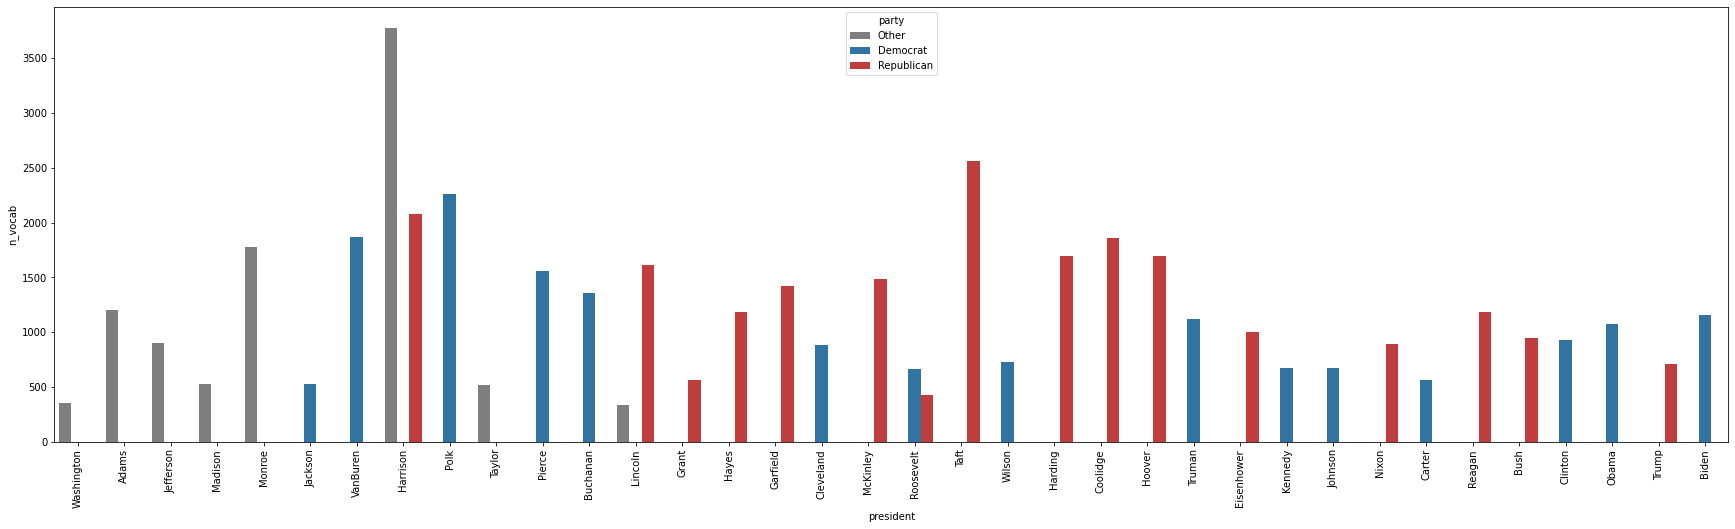

In [69]:
# color palette as dictionary
palette = {"Democrat":"tab:blue",
           "Republican":"tab:red", 
           "Other":"tab:gray"}

plt.figure(figsize=(30,8))

x_labels = list(df_updated.president)

fig = sns.barplot(
    data=df_updated, 
    x='president', y='n_vocab', 
    hue='party',
    palette=palette,
    errorbar=None)

# plt.xlabel("President", size=14)
#plt.ylabel("No. of vocabularies", size=14)
plt.xticks(rotation=90)

# fig.set_xticklabels(x_labels)
# fig.bar_label(fig.containers[0], label_type='edge')

# plt.savefig("How_to_specify_your_own_color_pallete_Seaborn_Python.png")

##### What are the five most frequently used words (exclusive of stop words) used by each president? What are the five most frequently words used collectively by all Democratic presidents versus Republican presidents? (2 point)

##### What are the key themes (e.g., freedom, liberty, country, etc.) used by each president in their inaugural speech? (3 points)

In [6]:
# top 3 themes
# use LDA

##### Compute a sentiment (positive/negative) for each presidential speech, and draw a barplot of the sentiment of all presidential speeches in chronological order. Again, color code the speeches as blue for Democrat, red for Republican, and gray for Other. Which of these groups have higher mean sentiment score? Who are the top three presidents with the highest positive sentiment in each group? (2 points)

,year,president,n_vocab
13,1841,Harrison,3776
30,1909,Taft,2562
14,1845,Polk,2260
25,1889,Harrison,2079
8,1821,Monroe,2022


In [27]:
# presidents with least vocabularies
df_updated.sort_values(by=['n_vocab'], ascending=False)[['year','president', 'n_vocab']][-3:]

,year,president,n_vocab
19,1865,Lincoln,334
39,1945,Roosevelt,251
1,1793,Washington,60
